In [1]:
# Imports
import os
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling

pd.set_option('display.max_rows', None,'display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti

from sklearn.preprocessing import Imputer, StandardScaler
#from sklearn import cross_validation
from sklearn import metrics

In [2]:
df = pd.read_csv('../input/Police_Department_Incidents_July2018.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


In [4]:
df.sample(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
1761378,80187076,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Thursday,02/21/2008,21:30,PARK,"ARREST, CITED",ASHBURY ST / WALLER ST,-122.446746,37.769075,"(37.7690753300241, -122.446746271794)",8018707665016
2016531,170127673,ASSAULT,THREATS AGAINST LIFE,Tuesday,02/14/2017,08:41,NORTHERN,"ARREST, BOOKED",100 Block of LARKIN ST,-122.416608,37.779139,"(37.779138754335285, -122.41660769511456)",17012767319057
105902,140479921,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,06/09/2014,12:30,RICHMOND,NONE,1100 Block of 9TH AV,-122.466504,37.766201,"(37.7662014296859, -122.466504397113)",14047992106244
39069,140557652,DRUG/NARCOTIC,POSSESSION OF COCAINE FOR SALES,Saturday,07/05/2014,16:54,NORTHERN,"ARREST, BOOKED",OFARRELL ST / LARKIN ST,-122.417904,37.785167,"(37.7851670875517, -122.417903977564)",14055765216622
1209512,60038825,ASSAULT,BATTERY,Tuesday,01/10/2006,23:42,TENDERLOIN,"ARREST, CITED",200 Block of MCALLISTER ST,-122.416578,37.780615,"(37.780614876154, -122.416577792446)",6003882504134


In [5]:
df.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
PdId            int64
dtype: object

In [6]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
missing_values_table(df)

Your selected dataframe has 13 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,type
PdDistrict,1,0.0,object


There is only one missing value in the dataset of the feature "PdDistrict". I will just drop this entry. 

In [8]:
i=df.index[df.isnull().any(axis=1)]
i

Int64Index([2013150], dtype='int64')

In [11]:
df.drop([2013150], axis=0, inplace=True)

In [12]:
df.shape

(2215023, 13)

### Inspect the remaining features one by one

In [16]:
df.sample(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
332555,40954376,MISSING PERSON,FOUND PERSON,Wednesday,08/18/2004,06:17,PARK,NONE,2400 Block of GEARY BL,-122.443597,37.782644,"(37.7826435280939, -122.443597047511)",4095437675000
68951,140111076,ASSAULT,BATTERY OF A POLICE OFFICER,Friday,02/07/2014,08:03,RICHMOND,"ARREST, BOOKED",6100 Block of CALIFORNIA ST,-122.483417,37.784009,"(37.7840094409015, -122.48341727912)",14011107604154
246729,90573716,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Wednesday,06/03/2009,22:57,MISSION,NONE,CESAR CHAVEZ ST / CHURCH ST,-122.427049,37.747696,"(37.7476955142307, -122.427048581348)",9057371603011
179608,150216434,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,03/10/2015,19:50,CENTRAL,"ARREST, BOOKED",COLUMBUS AV / BROADWAY ST,-122.406670,37.797864,"(37.7978641744394, -122.406669739951)",15021643465010
845144,90464579,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Monday,04/27/2009,08:30,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",9046457964070


#### IncidentNum

In [19]:
df.IncidntNum.describe()

count    2.215023e+06
mean     1.040727e+08
std      4.612826e+07
min      3.979000e+03
25%      6.124170e+07
50%      1.011558e+08
75%      1.409256e+08
max      9.915824e+08
Name: IncidntNum, dtype: float64

In [17]:
len(df.IncidntNum.unique())

1746913

#### Category

In [18]:
df.Category.describe()

count           2215023
unique               39
top       LARCENY/THEFT
freq             480447
Name: Category, dtype: object

In [21]:
df.Category.value_counts(normalize=True)

LARCENY/THEFT                  0.216904
OTHER OFFENSES                 0.139664
NON-CRIMINAL                   0.107594
ASSAULT                        0.087897
VEHICLE THEFT                  0.057156
DRUG/NARCOTIC                  0.054008
VANDALISM                      0.052396
WARRANTS                       0.045769
BURGLARY                       0.041328
SUSPICIOUS OCC                 0.036317
MISSING PERSON                 0.029327
ROBBERY                        0.025222
FRAUD                          0.018755
SECONDARY CODES                0.011662
FORGERY/COUNTERFEITING         0.010406
WEAPON LAWS                    0.010038
TRESPASS                       0.008780
PROSTITUTION                   0.007540
STOLEN PROPERTY                0.005368
SEX OFFENSES, FORCIBLE         0.005301
DISORDERLY CONDUCT             0.004533
DRUNKENNESS                    0.004436
RECOVERED VEHICLE              0.003935
DRIVING UNDER THE INFLUENCE    0.002561
KIDNAPPING                     0.002414


The top crime is "LARCENY/THEFT" (22%, 480k incidents)

#### Descript

In [22]:
df.Descript.describe()

count                          2215023
unique                             915
top       GRAND THEFT FROM LOCKED AUTO
freq                            178835
Name: Descript, dtype: object

In [29]:
df[['Category','Descript']].sample(5)

,Category,Descript
683957,LARCENY/THEFT,GRAND THEFT OF PROPERTY
1689665,OTHER OFFENSES,HARASSING PHONE CALLS
1951720,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL
246704,ROBBERY,"ROBBERY ON THE STREET, STRONGARM"
1513778,OTHER OFFENSES,PAROLE VIOLATION


"Descript" is included in "Category", but with more details (e.g., location, results, etc). 

#### DayOfWeek

In [30]:
df.DayOfWeek.describe()

count     2215023
unique          7
top        Friday
freq       337941
Name: DayOfWeek, dtype: object

In [32]:
df.DayOfWeek.value_counts()

Friday       337941
Wednesday    324020
Saturday     320593
Thursday     316156
Tuesday      315135
Monday       306587
Sunday       294591
Name: DayOfWeek, dtype: int64

Text(0.5,1,'Day of week')

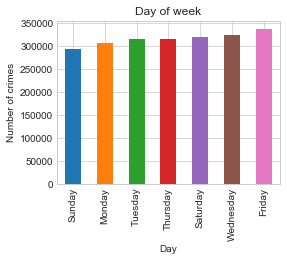

In [37]:
plt.figure(figsize=(4,3))
df['DayOfWeek'].value_counts().sort_values().plot.bar()
plt.xlabel('Day')
plt.ylabel('Number of crimes')
plt.title('Day of week')

Friday has the most number of crimes, while Sunday is the safest day.

#### Date

In [38]:
df.Date.describe()

count        2215023
unique          5613
top       01/01/2011
freq             650
Name: Date, dtype: object

In [39]:
df.Date.sample()

277942    08/29/2008
Name: Date, dtype: object

This indicates the date of the crime, which may be useful when doing the time series analysis. Let's first convert "Date" to "Year", "Month", "Day"

In [70]:
from datetime import datetime

#%timeit pd.to_datetime(df.Date, infer_datetime_format=True)

4.39 s ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
df.Date =  pd.to_datetime(df.Date, infer_datetime_format=True)

In [75]:
df.Date.sample()

691803   2011-10-04
Name: Date, dtype: datetime64[ns]

In [76]:
# create a scalar "length" to describe the length of time [in years] since the date of the incident to today. 
dttoday = datetime.now().strftime('%Y-%m-%d')
df['length'] = df.Date.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

In [99]:
df['Year'] = df.Date.map(lambda x: int(x.strftime('%Y-%m-%d').split('-')[0]))
df['Month'] = df.Date.map(lambda x: int(x.strftime('%Y-%m-%d').split('-')[1]))
df['Day'] = df.Date.map(lambda x: int(x.strftime('%Y-%m-%d').split('-')[2]))

In [116]:
df.Year.value_counts().sort_values()

2018     46668
2011    132697
2010    133523
2007    137639
2006    137853
2009    139860
2012    140847
2008    141311
2005    142186
2004    148148
2003    149176
2014    150128
2016    150882
2013    152806
2017    154773
2015    156526
Name: Year, dtype: int64

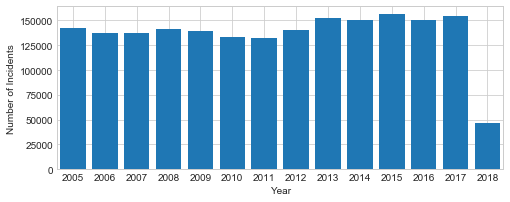

In [126]:
# visulize in a bar plot
fig = plt.figure(figsize=[8, 3])
plt.bar(sorted(df.Year.value_counts().index), df.Year.value_counts().values[np.argsort(df.Year.value_counts().index)])
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xlim((2004.5,2018.5))
#plt.ylim((150000,200000))
plt.xticks(np.arange(2005,2019) )
plt.show()

2018 is imcomplete. Among other years, 2015 has the most number of incidents. 

In [110]:
df.Month.value_counts().sort_values()

12    170776
6     174744
11    175032
2     178619
7     181822
9     183437
8     187379
5     187747
4     189834
10    190470
3     197580
1     197583
Name: Month, dtype: int64

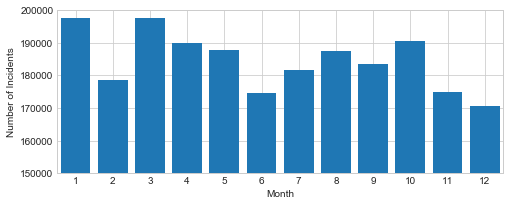

In [130]:
# visulize in a bar plot
fig = plt.figure(figsize=[8, 3])
plt.bar(sorted(df.Month.value_counts().index), df.Month.value_counts().values[np.argsort(df.Month.value_counts().index)])
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xlim((0.5,12.5))
plt.ylim((150000,200000))
plt.xticks( np.arange(1,13) )
plt.show()

January and March has the most number of the incidents, while June and February has the least number of the incidents. Holiday season (December, November) is not that bad. 

In [127]:
#df.Day.value_counts().sort_values()

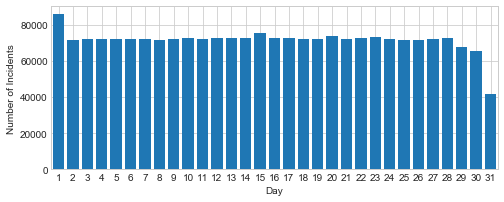

In [131]:
# visulize in a bar plot
fig = plt.figure(figsize=[8,3])
plt.bar(sorted(df.Day.value_counts().index), df.Day.value_counts().values[np.argsort(df.Day.value_counts().index)])
plt.xlabel('Day')
plt.ylabel('Number of Incidents')
plt.xlim((0.5,31.5))
#plt.ylim((150000,200000))
plt.xticks( np.arange(1,32) )
plt.show()

Interestingly, the first day of a month has significant higher number of incidents, and the last day of a month has the lowerest number. 

#### Time

In [40]:
df.Time.describe()

count     2215023
unique       1439
top         12:00
freq        57232
Name: Time, dtype: object

In [55]:
df.Time.value_counts().nlargest(5)

12:00    57232
00:01    56404
18:00    48564
17:00    42266
19:00    41862
Name: Time, dtype: int64

In [56]:
df.Time.value_counts().nsmallest(5)

05:32    103
05:31    105
06:01    110
05:23    110
05:38    114
Name: Time, dtype: int64

It seems that the most dangerous time of the day with the most number of crimes are around midnight, and around sunset. The 12:00 is suspecious here. Does it mean noon time or midnight? Let's convert "Time" to float values and check its distribution. 

In [135]:
df['Time_float'] = df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

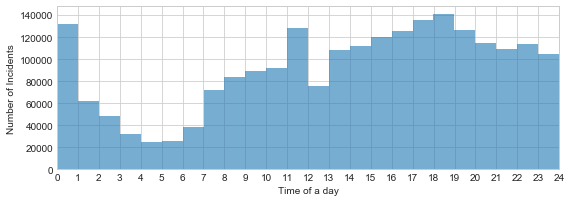

In [136]:
# visulize in a histogram plot
fig = plt.figure(figsize=[9,3])
plt.hist(df['Time_float'], bins=24, alpha = 0.6)
plt.xlabel('Time of a day')
plt.ylabel('Number of Incidents')
plt.xlim((0.0, 24))
plt.xticks( np.arange(0,25) )
plt.show()

So, there are significantly more incidents around midnight and noon (?!) time. I didn't expect noon is so unsave. Let's check what are the crimes arond noon time. 

In [166]:
# at Noon
df['Category'].loc[(df.Time_float > 11.5) & (df.Time_float < 12.5)].value_counts().nlargest(5)

LARCENY/THEFT     22770
OTHER OFFENSES    18510
NON-CRIMINAL      15962
ASSAULT            9124
DRUG/NARCOTIC      5561
Name: Category, dtype: int64

In [169]:
# at Midnight
df['Category'].loc[(df.Time_float > 23) | (df.Time_float < 1.5)].value_counts().nlargest(5)

LARCENY/THEFT     38661
OTHER OFFENSES    37197
ASSAULT           22681
NON-CRIMINAL      20276
VANDALISM         13267
Name: Category, dtype: int64

In [170]:
# overall
df['Category'].value_counts().nlargest(5)

LARCENY/THEFT     480447
OTHER OFFENSES    309358
NON-CRIMINAL      238323
ASSAULT           194694
VEHICLE THEFT     126602
Name: Category, dtype: int64

Comparing the types of the indidents at noon, at midnight & during the day, we can see that "LARCENY/THEFT" and "OTHER OFFENSES" are the most 2 common incidents. At noon, there are more "Durg/NAROCOTIC", while at midnight, there are more, "ASSAULT" and "VANDALISM". I think this makes sense. 

In [174]:
# number of incidents at day/night
print('number of incidents before 12pm:', df.loc[(df.Time_float < 12)].shape[0])
print('number of incidents after 12pm:', df.loc[(df.Time_float >= 12)].shape[0])

number of incidents before 12pm: 770018
number of incidents after 12pm: 1445005


The number of incidents in the afternoon and before midnight is double the number of incidents in the morning. 

#### PdDistrict

In [58]:
df.PdDistrict.describe()

count      2215023
unique          10
top       SOUTHERN
freq        399785
Name: PdDistrict, dtype: object

In [59]:
df.PdDistrict.value_counts()

SOUTHERN      399785
MISSION       300076
NORTHERN      272713
CENTRAL       226255
BAYVIEW       221000
INGLESIDE     194180
TENDERLOIN    191746
TARAVAL       166971
PARK          125479
RICHMOND      116818
Name: PdDistrict, dtype: int64

A map of the Police station distribution can be found [here:](http://sanfranciscopolice.org/police-district-maps), and shown below.

<img src="Citywide_District_Map.png">

#### Resolution

In [65]:
df.Resolution.sample(5)

1509969    NONE
526370     NONE
555824     NONE
721077     NONE
251846     NONE
Name: Resolution, dtype: object

In [67]:
df.Resolution.value_counts(normalize=True)

NONE                                      0.627307
ARREST, BOOKED                            0.237008
ARREST, CITED                             0.069881
LOCATED                                   0.015559
PSYCHOPATHIC CASE                         0.013176
UNFOUNDED                                 0.010744
JUVENILE BOOKED                           0.006392
COMPLAINANT REFUSES TO PROSECUTE          0.003652
DISTRICT ATTORNEY REFUSES TO PROSECUTE    0.003591
NOT PROSECUTED                            0.003485
JUVENILE CITED                            0.002974
PROSECUTED BY OUTSIDE AGENCY              0.002289
EXCEPTIONAL CLEARANCE                     0.001922
JUVENILE ADMONISHED                       0.001356
JUVENILE DIVERTED                         0.000313
CLEARED-CONTACT JUVENILE FOR MORE INFO    0.000311
PROSECUTED FOR LESSER OFFENSE             0.000038
Name: Resolution, dtype: float64

Over 62% of the incidents are not resolved. Let's check if this feature is realated with other variables, e.g., incident types, seasons, etc

In [175]:
# how the resolution varies with the year/month/day
# group the resolution to "NONE" (not resolved) and "Other" (Resolved). and group the year/month/day by the resolution

#### Address

In [178]:
df.Address.value_counts().nlargest(5)

800 Block of BRYANT ST      65267
800 Block of MARKET ST      17439
2000 Block of MISSION ST    10858
1000 Block of POTRERO AV    10198
900 Block of MARKET ST       7843
Name: Address, dtype: int64

In [179]:
df.Address.describe()

count                    2215023
unique                     25147
top       800 Block of BRYANT ST
freq                       65267
Name: Address, dtype: object

This information will be useful for spatial distribution analysis.

#### X, Y, Location

In [188]:
df[['X','Y','Location']].head(5)

,X,Y,Location
0,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)"
1,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)"
2,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)"
3,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)"
4,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)"


The information in X, Y are included in Location. "X""Y" are more convinient to use though. 

In [189]:
df.X.dtypes

dtype('float64')

In [190]:
df.Location.dtypes

dtype('O')

#### PdId

In [191]:
df.PdId.describe()

count    2.215023e+06
mean     1.040727e+13
std      4.612826e+12
min      3.979630e+08
25%      6.124170e+12
50%      1.011558e+13
75%      1.409256e+13
max      9.915824e+13
Name: PdId, dtype: float64

In [195]:
len(df.PdId.unique())

2215023

This is a uniqe case ID number for each indicents. Not quite useful. Let's check the dataframe again. 

In [198]:
df.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,length,Year,Month,Day,Time_float
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000,3.463014,2015,1,19,14.00
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074,3.427397,2015,2,1,15.75
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014,3.427397,2015,2,1,15.75
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200,3.427397,2015,2,1,15.75
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160,3.441096,2015,1,27,19.00


#### Useful features are:
- Incidents: Category, Resolution
- Time: "DayofWeek", "Time_float", "Year", "Month", "Day", "length"
- Spatial: "PdDistrict", "Address", "X""Y", 

Now, let's explore the spatial distribution of incidents

## Spatical Distribution

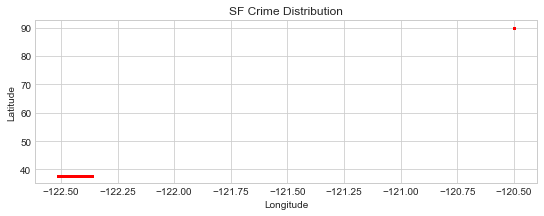

In [199]:
fig = plt.figure(figsize=[9,3])
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df.X, df.Y, s = 0.5, c = 'r')
plt.show()

There is an obvious outlier at (-120.5 90), which is probably a mistake/error in the dataset. Let's remove the outliers and plot again.

In [232]:
i = df.index[df.Y > 80]
i

Int64Index([ 231423,  247512,  269974,  290301,  312643,  319711,  331495,
             334751,  361446,  361707,
            ...
            1685251, 1706352, 1718610, 1734718, 1737742, 1743766, 1756779,
            1767233, 1769553, 1776160],
           dtype='int64', length=143)

In [230]:
df.shape

(2215023, 18)

In [234]:
df.drop(i, axis=0, inplace=True)

In [235]:
df.shape

(2214880, 18)

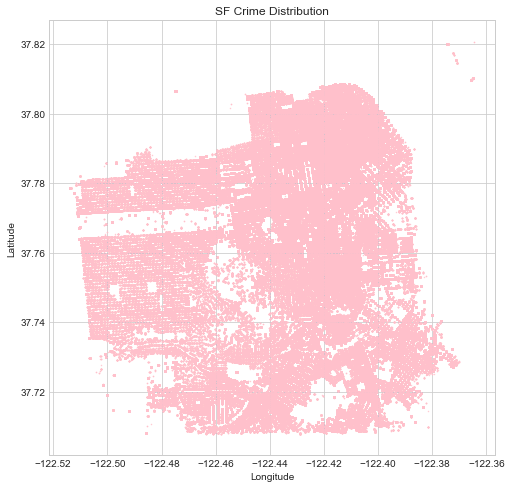

In [279]:
fig = plt.figure(figsize=[8,8])
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df.X, df.Y, s = 0.2, c = 'pink')
plt.show()

We can see that there are more crimes in the north-easten area of SF. 
Let's check whether this is consistent among the years.

In EDA, we found that January is the month of a year that has the most number of the incidents. So in the following, we only plot the January data of each year so save some time. 

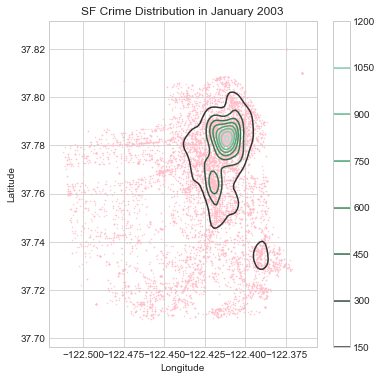

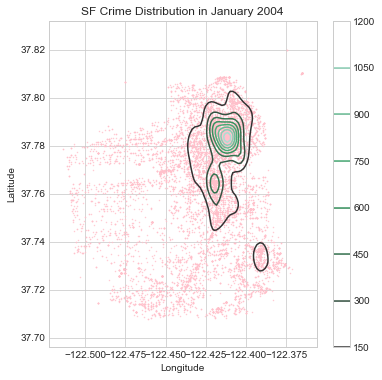

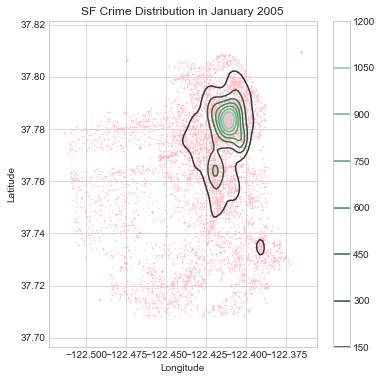

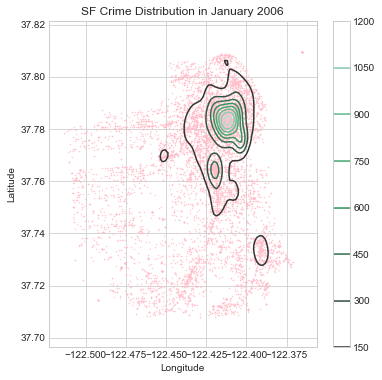

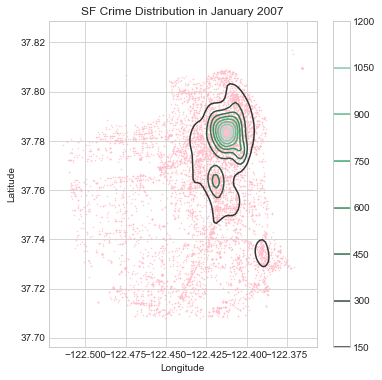

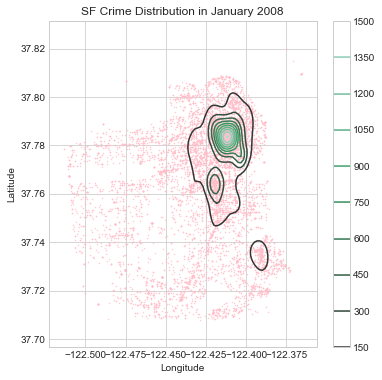

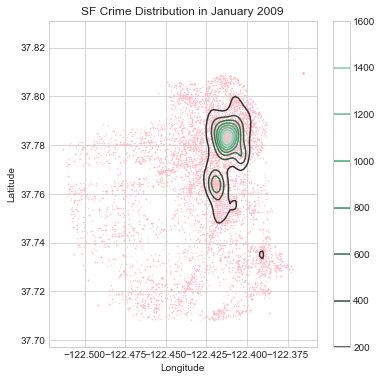

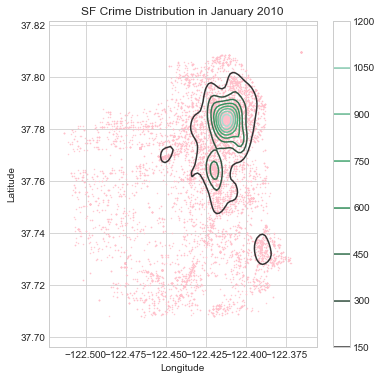

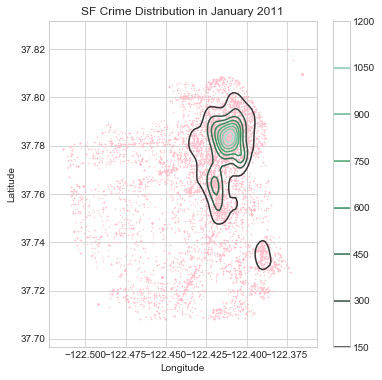

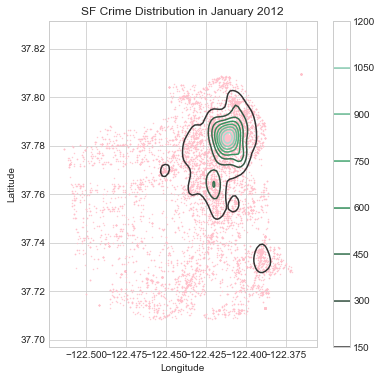

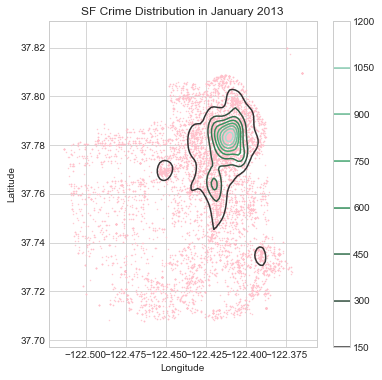

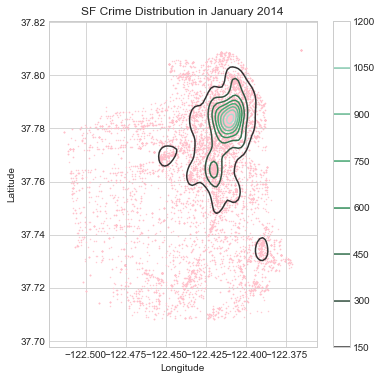

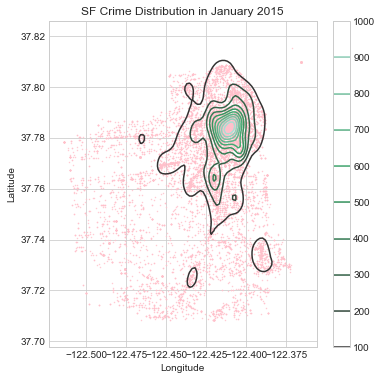

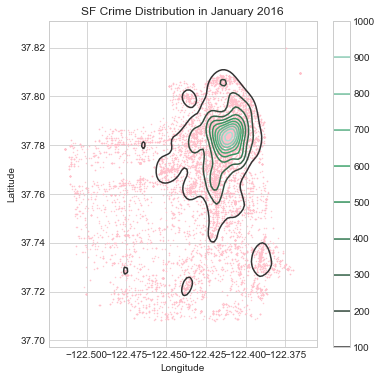

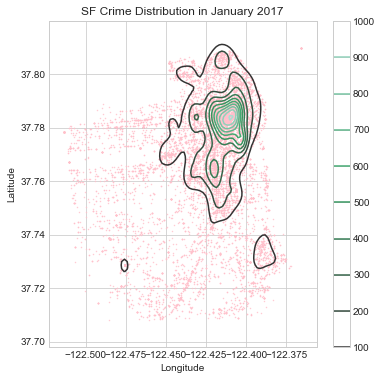

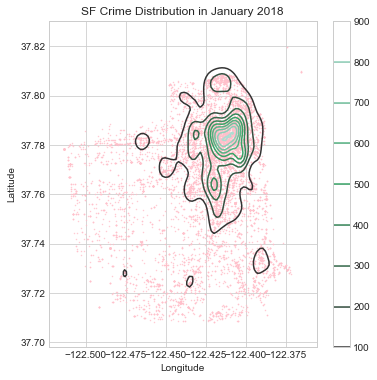

In [280]:
for yr in range(2003, 2019): 
    df_jan = df[(df.Month == 1) & (df.Year == yr)]
    fig = plt.figure(figsize=[6,6])
    plt.title('SF Crime Distribution in January ' + str(yr))
    # contour
    ax = sns.kdeplot(df_jan.X, df_jan.Y, cbar=True)
    # scatter
    plt.scatter(df_jan.X, df_jan.Y, s = 0.2, c = 'pink')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

It seems that the north-easter area has always been problematic during the past 15 years. 

### Time Series Analysis
Now i am going to check how the indicents evolve with time

In [281]:
df.Date.sample()

1287595   2004-08-03
Name: Date, dtype: datetime64[ns]

In [286]:
print('The time span is', df.length.max()-df.length.min(), 'years')

The time span is 15.378082191780821 years


In [289]:
df.isnull().any()

IncidntNum    False
Category      False
Descript      False
DayOfWeek     False
Date          False
Time          False
PdDistrict    False
Resolution    False
Address       False
X             False
Y             False
Location      False
PdId          False
length        False
Year          False
Month         False
Day           False
Time_float    False
dtype: bool

There are no missing values in our dataframe. 

First, we need to convert a data frame to time series data:

In [295]:
df.Date.max()

Timestamp('2018-05-15 00:00:00')

In [296]:
time_span = pd.date_range('2003-01-01', '2018-05-15')

In [297]:
def df_to_TimeSeries(df):
    date = pd.to_datetime(df.Date.value_counts().index)
    index = sorted(date)
    data = df.Date.value_counts().values[np.argsort(date)]
    ts = pd.DataFrame(data = data, index = index, columns = ['count'])
    # if a date within the time span does not exist, fill it in with count = 0
    ts = ts.reindex(time_span, fill_value=0) 
    return ts

Second, we need to include all of the categories of incidents.

In [304]:
all_numbers = df_to_TimeSeries(df)

In [310]:
all_numbers.describe()

,count
count,5614.000000
mean,394.527966
std,50.062464
min,0.000000
25%,363.000000
50%,394.000000
75%,426.000000
max,650.000000


The min number of incidents during a day is 0 (!) and the max number is 650, with a median at 394.

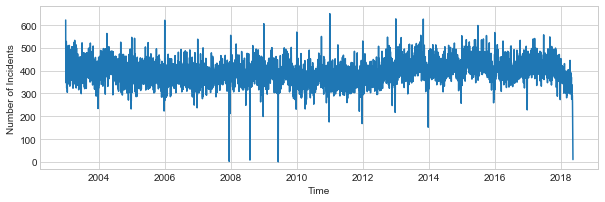

In [315]:
# plot the time series
fig = plt.figure(figsize=(10,3))
all_numbers['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of Incidents')
plt.show()

In [418]:
crimes = df.Category.value_counts().nlargest(10).index.tolist()
crimes

['LARCENY/THEFT',
 'OTHER OFFENSES',
 'NON-CRIMINAL',
 'ASSAULT',
 'VEHICLE THEFT',
 'DRUG/NARCOTIC',
 'VANDALISM',
 'WARRANTS',
 'BURGLARY',
 'SUSPICIOUS OCC']

In [422]:
# define a function to check the trend of the top 10 crimes
def check_crime(crime_name, full_name):
    """
    Covert a crime to time series;
    Visualize the trend of the crime
    - crime_name is the variable name in the dataframe
    - full_name is the full variable name
    """
    df_crime = df.loc[(df['Category'] == crime_name), :]
    crime_counts = df_to_TimeSeries(df_crime)
    fig = plt.figure(figsize=(10,3))
    crime_counts['count'].plot()
    plt.xlabel('Time')
    plt.ylabel('Number of '+ full_name+' Incidents')
    plt.title(full_name)
    plt.show()
    return crime_counts

Let's plot the time variation of the top 10 incidents in the past 15 years

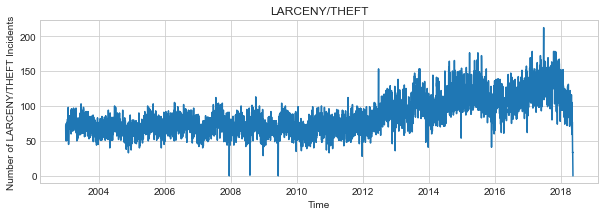

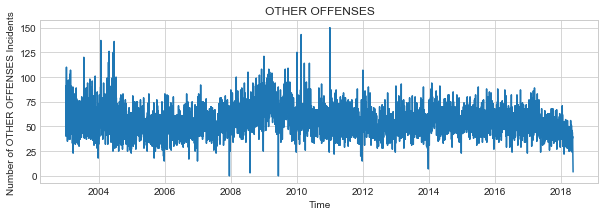

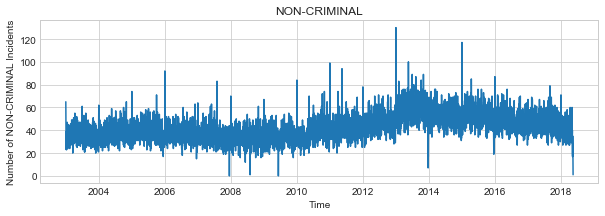

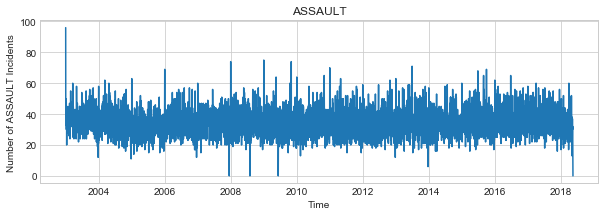

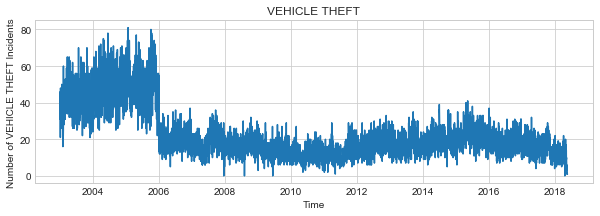

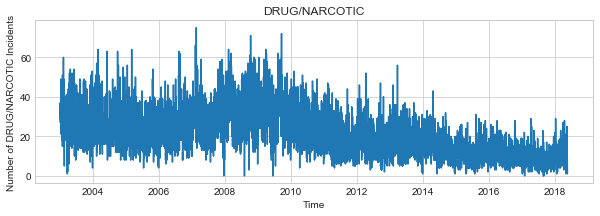

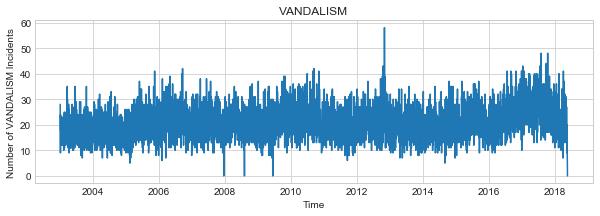

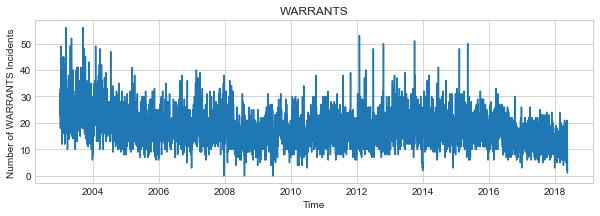

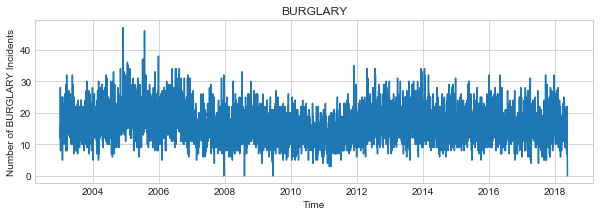

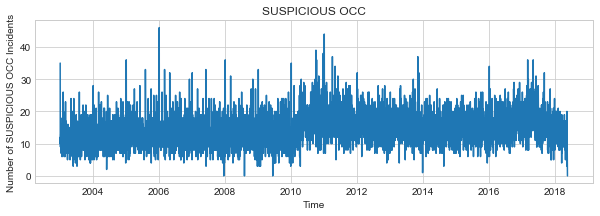

In [455]:
d = {}
for crime in crimes:
    #check_crime(crime, crime)
    d["counts_{0}".format(crime)] = check_crime(crime, crime)

We see some interesting trends in the top 10 incidents in the past 15 years:

- "LARCENY/THEFT" increase with time
- there is a slight peak of "OTHER OFFENSE" between 2008 and 2019
- "Non-Criminal" slowly increase since 2010
- "ASSAULT" remains almost the same
- "Vehicle THEFT" significantly dropped at the year of 2006 and then remain a lower level. -> (what happened in 2006)
- "Drug/NARCOTIC" slightly dropped since 2010. 
- "VANDALISM", "WARRANTS", "BURGLARY", & "SUSPICIOUS OCC" remains almost the same

I will further model these 10 types of incidents and statistically study them. I will use the ARIMA model to fit the data. To reduce the randomness of the data, we can rebin the time series into month intervals. This strategy can also magnify seasonal variations in the data, if any. 

### modeling of "LARCENY/THEFT"

In [425]:
d.keys()

dict_keys(['counts_LARCENY/THEFT', 'counts_OTHER OFFENSES', 'counts_NON-CRIMINAL', 'counts_ASSAULT', 'counts_VEHICLE THEFT', 'counts_DRUG/NARCOTIC', 'counts_VANDALISM', 'counts_WARRANTS', 'counts_BURGLARY', 'counts_SUSPICIOUS OCC'])

In [426]:
d['counts_LARCENY/THEFT'].describe()

,count
count,5614.000000
mean,85.575169
std,25.407219
min,0.000000
25%,67.000000
50%,79.000000
75%,100.000000
max,212.000000


In [427]:
y = d['counts_LARCENY/THEFT'].resample('MS').sum()

In [428]:
y.tail()

,count
2018-01-01,3820
2018-02-01,2914
2018-03-01,3104
2018-04-01,2922
2018-05-01,872


The data is only till 2018-05-15, so the data of May is incomplete. I will remove the data of May 2018

In [429]:
y = y[:-1]
y.tail()

,count
2017-12-01,4070
2018-01-01,3820
2018-02-01,2914
2018-03-01,3104
2018-04-01,2922


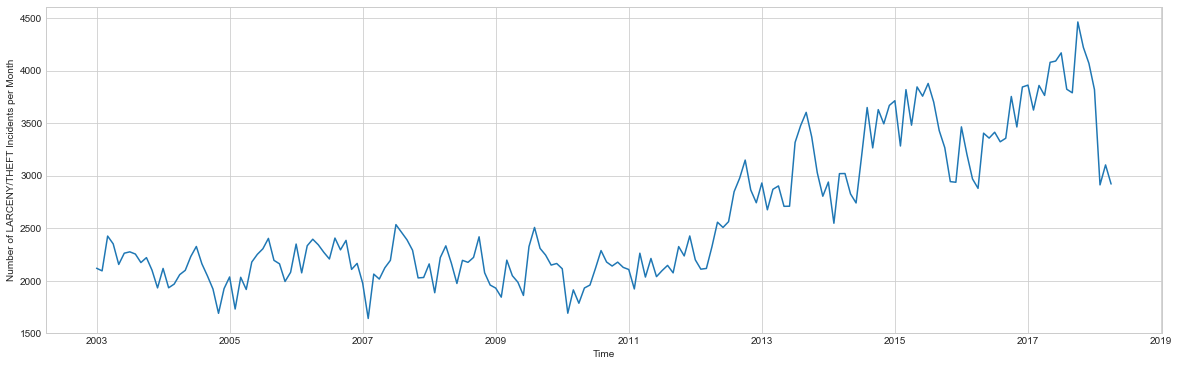

In [430]:
fig = plt.figure(figsize=(20,6))
y['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.show()

I will use the seasonal_decompose function from statsmodels to decompose our data into a trend, a seasonal pattern and the residual, to better identify whether or noth there is seasonality in the data.

In [432]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

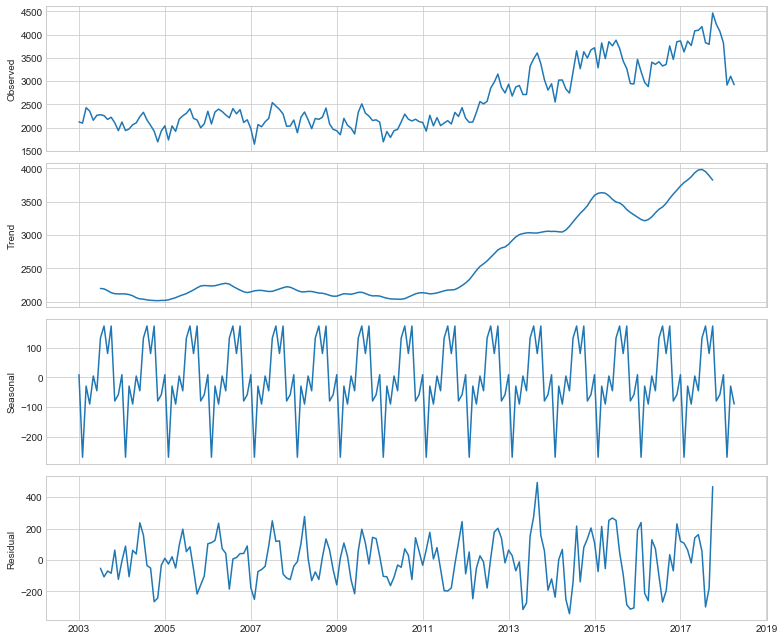

In [433]:
plt.rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [437]:
len(y)

184

I will continute with the seansonal ARIMA model and I will take the data from the latest 12 months as the testing set.

In [438]:
y_train, y_test = y[:-12], y[-12:]

I will use grid search to find the best hyperparameters of the model. S = 12 because I decided to use a seasonal period of one year. I use [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) to evalute the performance of each model.

In [439]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [446]:
import warnings
warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(y_train,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            print("(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 0, 12): AIC = 3175.807169527759
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 1, 12): AIC = 2783.1393664020557
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 0, 12): AIC = 2338.283684880375
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 1, 12): AIC = 2165.1702911559596
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 0, 12): AIC = 2343.807366306931
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 1, 12): AIC = 2306.9487811786857
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 0, 12): AIC = 2174.584226906758
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 1, 12): AIC = 2158.886442147977
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 0, 12): AIC = 2948.285992614018
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 1, 12): AIC = 2603.3346807371145
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 0, 12): AIC = 2236.391672644797
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 1, 12): AIC = 2061.949488145043
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 0, 12): AIC = 2259.91201471538
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 1, 12): AIC = 2198.0281085538863
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 0, 12): AIC = 2081.7996855305746
(p,d,

In [448]:
print("The Best parameters are: (p,d,q,P,D,Q,S) =", param)

The Best parameters are: (p,d,q,P,D,Q,S) = (1, 1, 1, 1, 1, 1, 12)


In [449]:
results  ==  best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6560,0.150,4.365,0.000,0.361,0.951
ma.L1,-0.8437,0.109,-7.731,0.000,-1.058,-0.630
ar.S.L12,-0.0424,0.093,-0.458,0.647,-0.224,0.139
ma.S.L12,-0.9808,0.539,-1.819,0.069,-2.038,0.076
sigma2,2.859e+04,1.34e+04,2.129,0.033,2268.089,5.49e+04


Let's evaluate the fitting results from the residuals. 

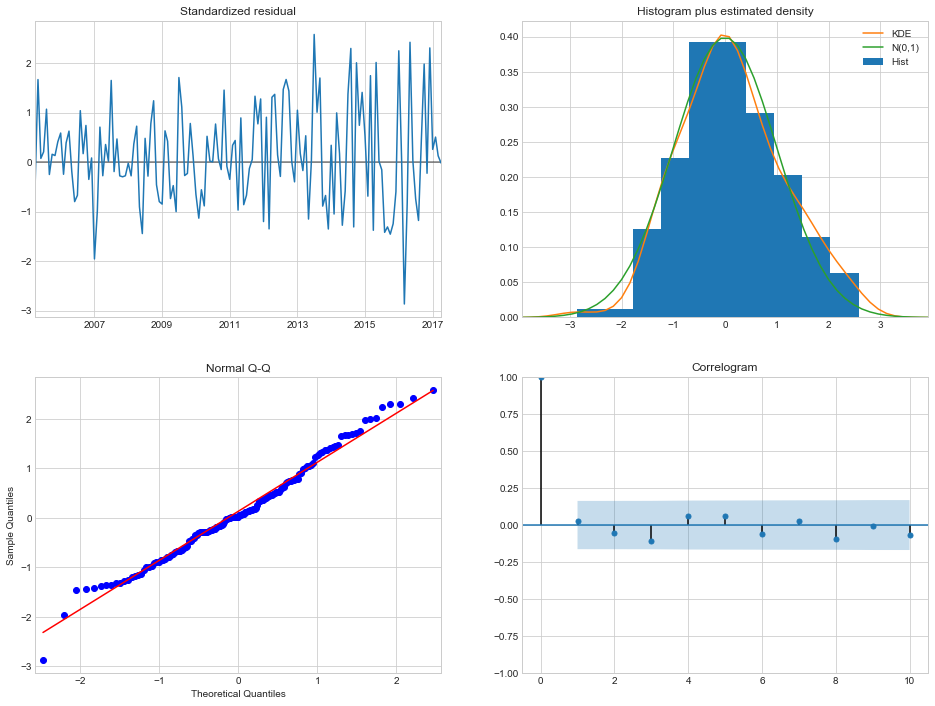

In [450]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

The residuals are close to normal distribution with mean at 0 and uncorrelated with each other. 

Our ARIMA model only takes a first-order difference, and I need to  check weather it is enough to make the time series become stationary. I will use the [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to do this.

In [453]:
from  statsmodels.tsa.stattools import adfuller

result = adfuller(y['count'].values[1:])
print("-- Before taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

diff = y.diff()
result = adfuller(diff['count'].values[1:])
print("-- After taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: -1.0654309848768888
p-value: 0.7286589796470294
-- After taking the difference --
ADF Statistic: -3.574418426872344
p-value: 0.006269352487521362


The p-value becomes drops to ~zero after taking the difference just once, so i can rejects the null hypothesis of nonstationarity.


Lastly, let's visually compare the observed time series and the model predictions.

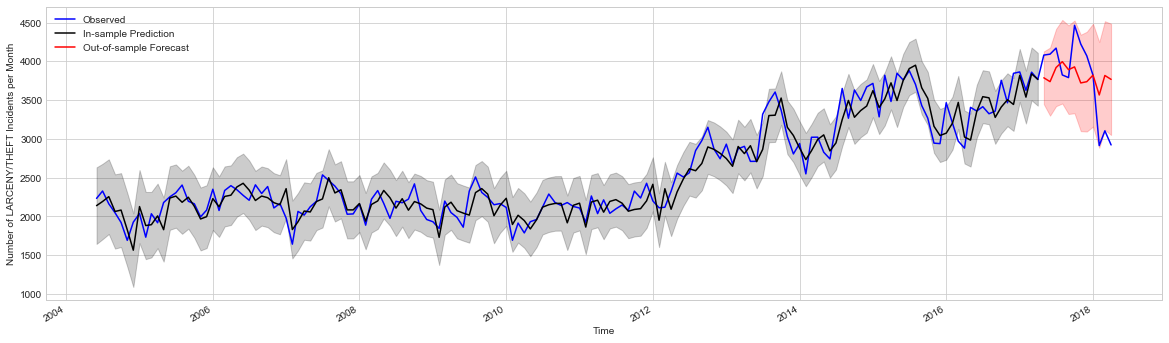

In [454]:
# neglect the beginning of the time series, where the model hasn't converged
pred = results.get_prediction(start = y_train['2004-06':].index[0],  dynamic=False)
pred_ci = pred.conf_int() # 95% confidence interval 

forecast = results.get_forecast(steps=12) # forecast for the next 12 months
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y['2004-06':].index, y['2004-06':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.legend()
plt.show()

### modeling of "NON-CRIMINAL"

In [456]:
y2 = d['counts_NON-CRIMINAL'].resample('MS').sum()

In [459]:
y2 = y2[:-1]

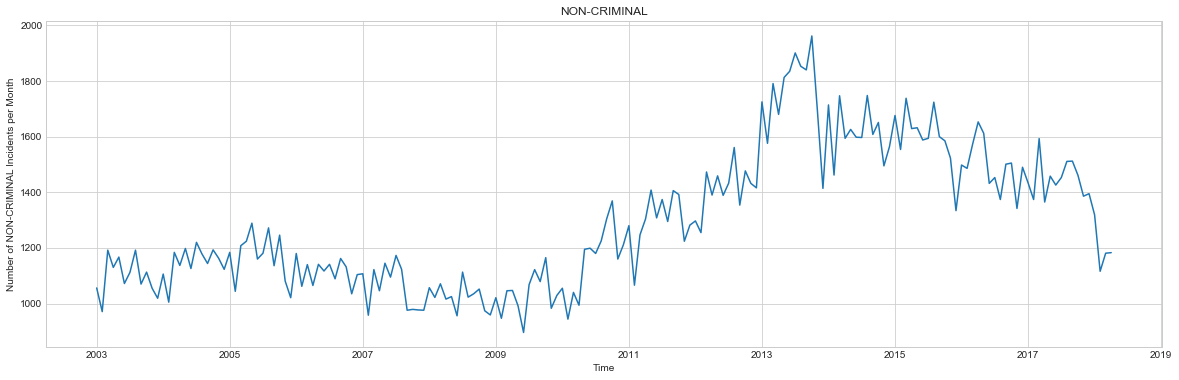

In [462]:
fig = plt.figure(figsize=(20,6))
y2['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of NON-CRIMINAL Incidents per Month')
plt.title('NON-CRIMINAL')
plt.show()

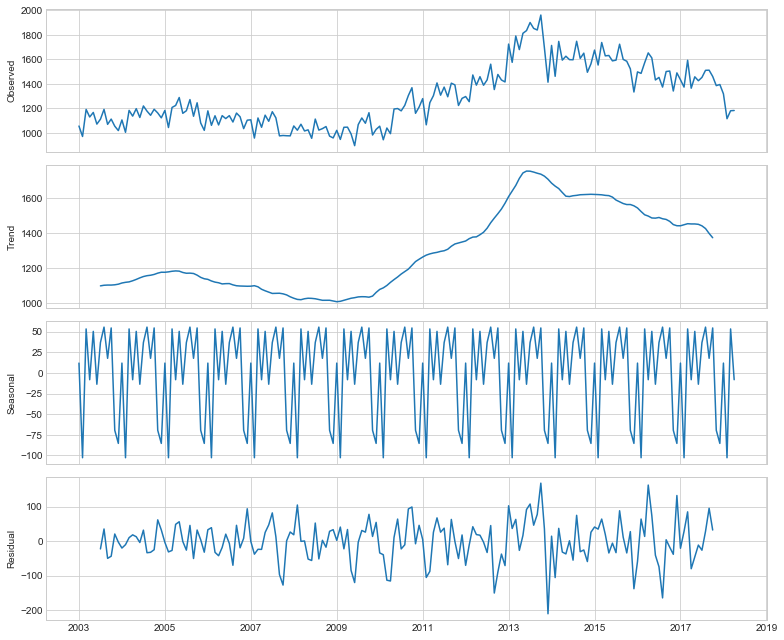

In [463]:
plt.rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(y2, model='additive')
decomposition.plot()
plt.show()

I'll use an seasonal ARIMA model with a seasonal period of one year. I will take the data from the last 12 months as the testing set.

In [464]:
y2_train, y2_test = y2[:-12], y2[-12:]

In [465]:
import  itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [467]:
warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(y2_train,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            print("(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 0, 12): AIC = 2942.8949112729742
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 1, 12): AIC = 2559.6572223822423
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 0, 12): AIC = 2058.766960340417
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 1, 12): AIC = 1914.744979633195
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 0, 12): AIC = 2070.801537207773
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 1, 12): AIC = 2060.328497522619
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 0, 12): AIC = 1926.9355159951424
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 1, 12): AIC = 1915.4786264529314
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 0, 12): AIC = 2723.2388042333823
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 1, 12): AIC = 2367.0112340401024
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 0, 12): AIC = 1977.2853203368588
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 1, 12): AIC = 1832.3402950670566
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 0, 12): AIC = 2002.2981892568012
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 1, 12): AIC = 1973.9165932926248
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 0, 12): AIC = 1854.328727412797


In [468]:
print("The Best parameters are: (p,d,q,P,D,Q,S) =", param)

The Best parameters are: (p,d,q,P,D,Q,S) = (0, 1, 1, 0, 1, 1, 12)


In [469]:
results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4694,0.076,-6.156,0.000,-0.619,-0.320
ma.S.L12,-1.0000,0.091,-10.981,0.000,-1.178,-0.822
sigma2,5686.2968,1.6e-05,3.55e+08,0.000,5686.297,5686.297


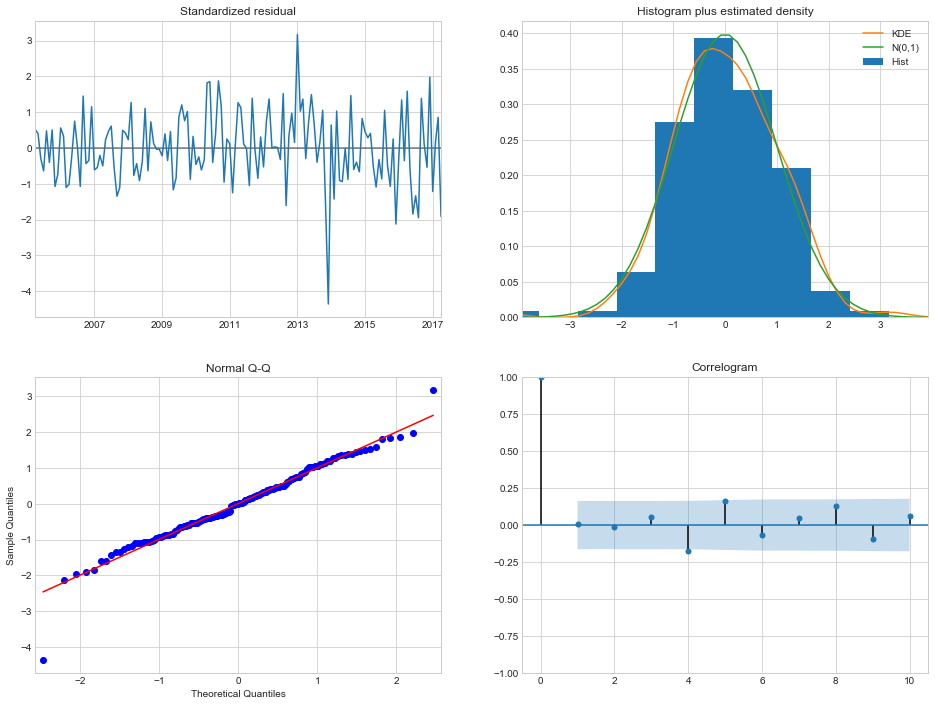

In [470]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

In [471]:
from  statsmodels.tsa.stattools import adfuller

result = adfuller(y2['count'].values[1:])
print("-- Before taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

diff = y2.diff()
result = adfuller(diff['count'].values[1:])
print("-- After taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: -1.3986581373235734
p-value: 0.5829192550170835
-- After taking the difference --
ADF Statistic: -2.7822401359009206
p-value: 0.06085576163619144


well, the current model seems not quite good, at least not doing a good job as for the "THEFT"

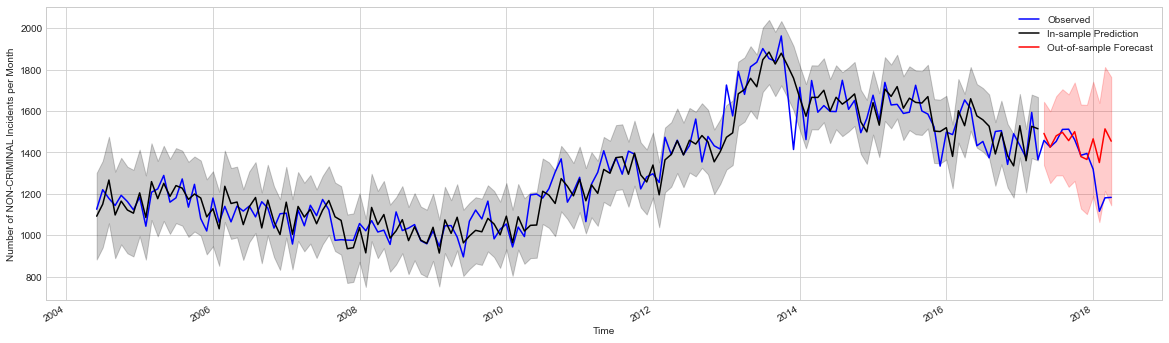

In [472]:
# neglect the beginning of the time series, where the model hasn't converged
pred = results.get_prediction(start = y2_train['2004-06':].index[0],  dynamic=False)
pred_ci = pred.conf_int() # 95% confidence interval 

forecast = results.get_forecast(steps=12) # forecast for the next 12 months
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y2['2004-06':].index, y2['2004-06':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of NON-CRIMINAL Incidents per Month')
plt.legend()
plt.show()
